In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.tree import DecisionTreeRegressor

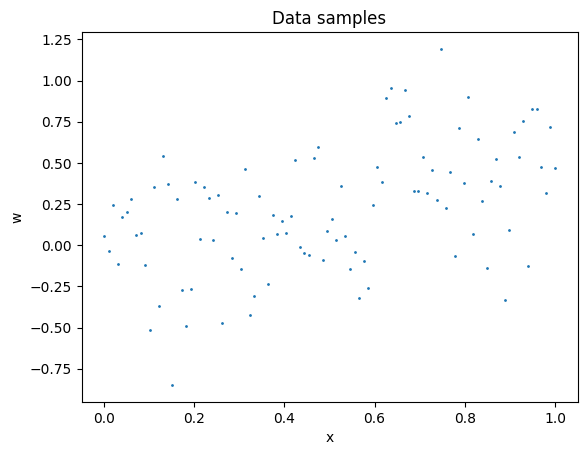

In [2]:
# Generate samples (x, w)
N = 100
w = np.zeros(N)
x = np.linspace(0, 1, N)

# Case 1
# w[x < 0.5]  = np.random.normal(0, 0.1, np.sum(x < 0.5))
# w[x >= 0.5] = np.random.normal(1, 0.1, np.sum(x >= 0.5))

# Case 2
# w = x + np.random.normal(0, 0.1, N)

# Case 3
noise_level = 0.3
a = 0.6
b = 0.65
w[x < a] = np.random.normal(0, noise_level, np.sum(x < a))
m = (x >= a) & (x < b)
w[m] = (x[m] - a) / (b - a) + np.random.normal(0, noise_level, np.sum(m))
del m
w[x >= b] = 0.5 + np.random.normal(0, noise_level, np.sum(x >= b))

plt.figure()
plt.scatter(x, w, s=1)
plt.xlabel('x')
plt.ylabel('w')
plt.title('Data samples')
plt.show()

In [3]:
# Plot the weight distribution on the point space
def plot_weight_image(x, y, weight, bins=100):
    plt.figure()
    extent = [np.min(x), np.max(x), np.min(y), np.max(y)]
    col = np.clip(((x - extent[0]) / (extent[1] - extent[0]) * bins).astype(int), 0, bins-1)
    row = np.clip(((extent[3] - y) / (extent[3] - extent[2]) * bins).astype(int), 0, bins-1)
    weight_sum_im = csr_matrix((weight, (row, col)), shape=(bins, bins)).toarray()
    count_im = csr_matrix((np.ones_like(weight), (row, col)), shape=(bins, bins)).toarray()
    weight_im = weight_sum_im
    weight_im[count_im == 0] = -0.1
    weight_im[count_im > 0] /= count_im[count_im > 0]
    plt.imshow(weight_im, cmap='viridis', interpolation='nearest', extent=extent, aspect='auto')

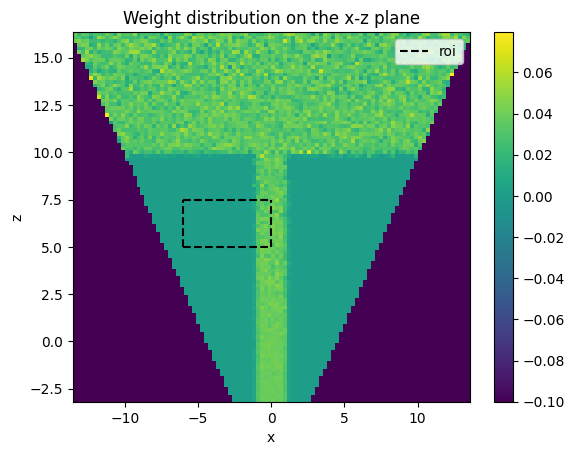

In [13]:
# Load real sample data
folder = '/Users/james/Test/thesis_experiments/data/plane-two-shadows-samples-vs+_rel_d4_l32k'
i = 2
position = np.load(f"{folder}/position-{i}.npy", allow_pickle=True)
weight = np.load(f"{folder}/weight-{i}.npy", allow_pickle=True)
assert len(weight) == len(position)

plot_weight_image(position[:, 0], position[:, 2], weight, bins=100)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("z")
plt.title("Weight distribution on the x-z plane")

roi = [-6, 0, 5, 7.5]
# roi = [-5, 5, 0, 2.5]
# roi = [-7, 3, 10, 12.5]
# roi = [0, 5, 5, 15]
# Plot a dashed rectangle frame for the region of interest
plt.plot([roi[0], roi[0]], [roi[2], roi[3]], 'k--', label='roi')
plt.plot([roi[1], roi[1]], [roi[2], roi[3]], 'k--')
plt.plot([roi[0], roi[1]], [roi[2], roi[2]], 'k--')
plt.plot([roi[0], roi[1]], [roi[3], roi[3]], 'k--')
plt.legend()
plt.show()

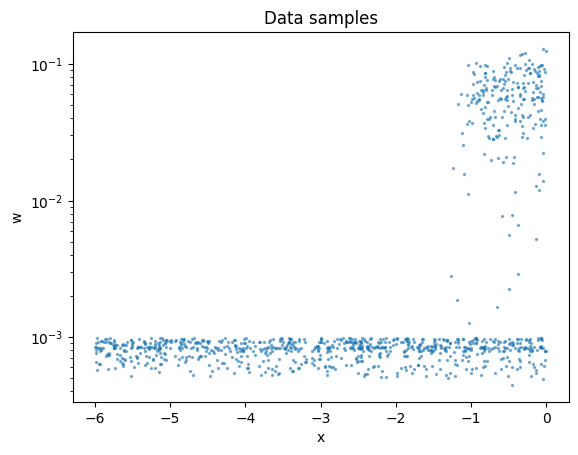

In [14]:
x, z = position[:, 0], position[:, 2]
mask = (x >= roi[0]) & (x <= roi[1]) & (z >= roi[2]) & (z <= roi[3])
x = x[mask]
z = z[mask]
w = weight[mask]
N = 1000
indices = np.random.choice(len(x), N, replace=False)
x = x[indices]
z = z[indices]
w = w[indices]
# print(f"Number of samples in the region of interest: {N}")

plt.figure()
plt.scatter(x, w, s=2, alpha=0.5)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('w')
plt.title('Data samples')
plt.show()

Optimal x: -0.9965823888778687, cost: 0.00015570403537265153, left ratio: 0.669
Optimal z: 6.117148399353027, cost: 0.00035763783944025635, left ratio: 0.488


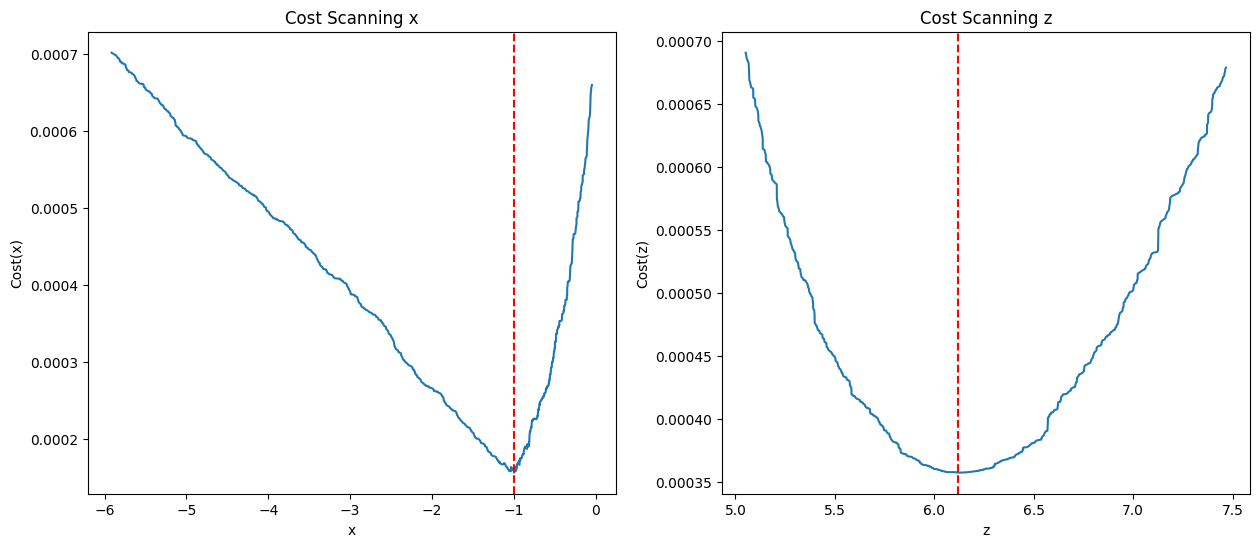

Split at x = -0.9965823888778687


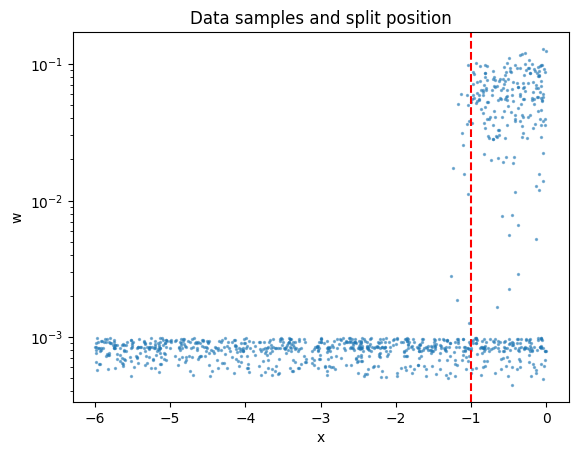

In [15]:
# Find x such that |Sl|^2/|S|^2 Var[W | X < x] + |Sr|^2/|S|^2 Var[W | X >= x] is minimized
def find_split(x, w, x_str="", ax=None):
    min_samps_per_side = 16
    costs = np.full(N, np.inf)
    indices = np.argsort(x)
    x = x[indices]
    w = w[indices]
    # chi2_div = np.var(w) / w.mean()**2
    for i in range(min_samps_per_side, N - min_samps_per_side):
        # Sum of Chi2 divergence plus a penalty term
        costs[i] = (i/N)**2 * np.var(w[:i], ddof=1) + (1 - i/N)**2 * np.var(w[i:], ddof=1)
        # costs[i] = np.var(w[:i]) / w[:i].mean()**2 + np.var(w[i:]) / w[i:].mean()**2 + 1.0*chi2_div * np.abs(i / N - 0.5)

    min_idx = np.argmin(costs)
    min_x = x[min_idx]
    min_cost = costs[min_idx]
    if len(x_str) > 0:
        print(f'Optimal {x_str}: {min_x}, cost: {min_cost}, left ratio: {min_idx / N}')

    if ax:
        ax.plot(x, costs)
        ax.axvline(min_x, color='r', linestyle='--')
        ax.set_xlabel(x_str)
        ax.set_ylabel(f'Cost({x_str})')
        ax.set_title(f'Cost Scanning {x_str}')

    return min_x, min_cost


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
x_split, cost_x = find_split(x, w, 'x', ax1)
z_split, cost_z = find_split(z, w, 'z', ax2)
plt.show()
if cost_x < cost_z:
    print(f"Split at x = {x_split}")
else:
    print(f"Split at z = {z_split}")
    
plt.figure()
plt.scatter(x, w, s=2, alpha=0.5)
plt.axvline(x_split, color='r', linestyle='--')
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('w')
plt.title('Data samples and split position')
plt.show()

Optimal x: -0.08703499287366867, cost: 0.0004211914813278127, left ratio: 0.507
Optimal z: 0.561496913433075, cost: 0.0004212189226207556, left ratio: 0.5025
Cost_x after penalization: 0.000994010549288308
Cost_z after penalization: 0.001034705771786221


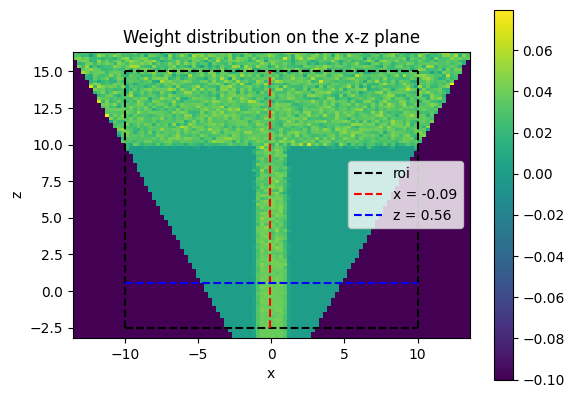

Optimal x: -1.0538283586502075, cost: 0.00014354470737125663, left ratio: 0.67
Optimal z: 6.09432315826416, cost: 0.00034457056422205644, left ratio: 0.498
Cost_x after penalization: 0.00018895969830988788
Cost_z after penalization: 0.0005898255062751123


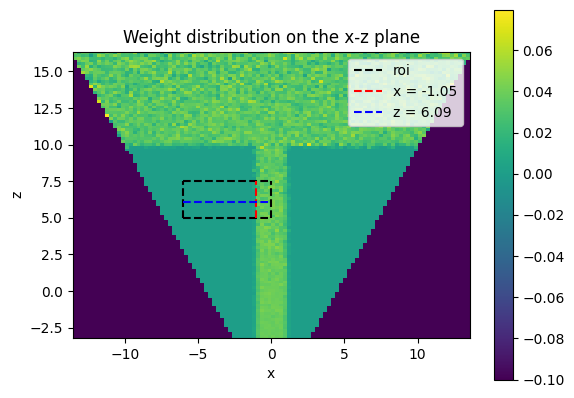

Optimal x: 0.9250433444976807, cost: 0.00038399511950551826, left ratio: 0.531
Optimal z: 1.0006940364837646, cost: 0.0004933782491569292, left ratio: 0.4905
Cost_x after penalization: 0.000505484341868263
Cost_z after penalization: 0.0008845235728147262


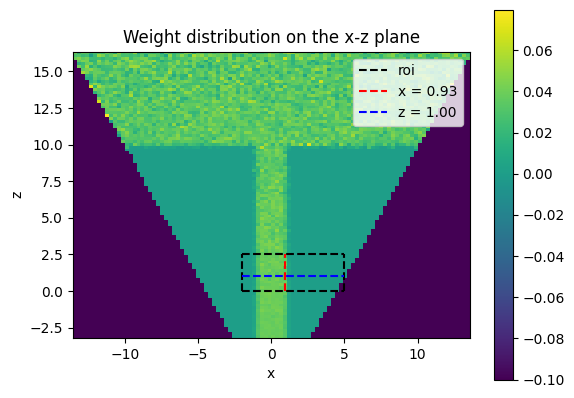

Optimal x: -0.8279505372047424, cost: 0.00039455558215267957, left ratio: 0.49
Optimal z: 3.080745220184326, cost: 0.00044067049343467804, left ratio: 0.5185
Cost_x after penalization: 0.0008417462611808121
Cost_z after penalization: 0.0008792532288689541


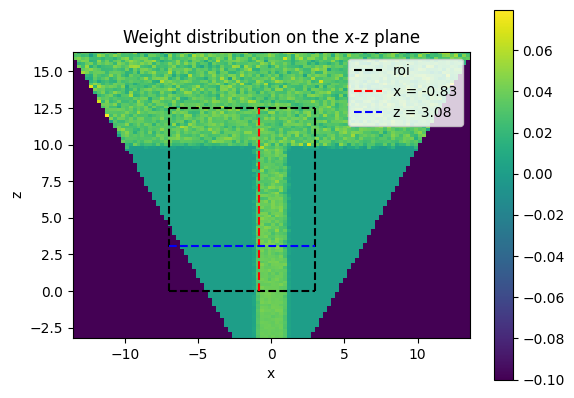

Optimal x: 1.9506940841674805, cost: 0.00046172374126908836, left ratio: 0.4475
Optimal z: 9.821442604064941, cost: 0.00041975782689498736, left ratio: 0.518
Cost_x after penalization: 0.0009212599808806532
Cost_z after penalization: 0.0006802832911707799


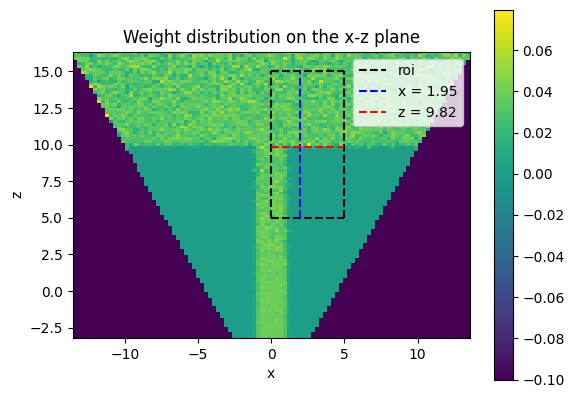

Optimal x: 2.5538594722747803, cost: 2.58195084463857e-08, left ratio: 0.511
Optimal z: 1.2543658018112183, cost: 2.4849919574208457e-08, left ratio: 0.466
Cost_x after penalization: 4.184455668699948e-08
Cost_z after penalization: 2.4849919574208457e-08


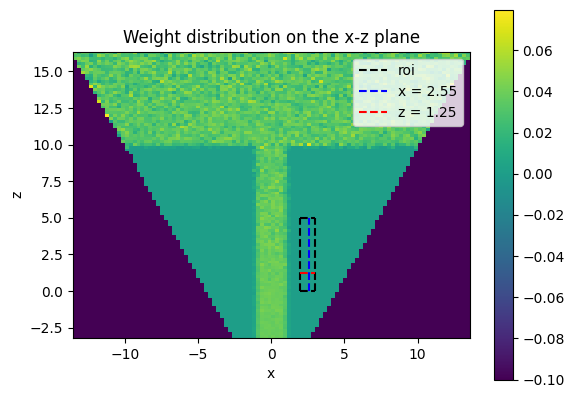

Optimal x: -7.027947425842285, cost: 0.0005195794726206514, left ratio: 0.4945
Optimal z: 12.750532150268555, cost: 0.0005197277378067374, left ratio: 0.504
Cost_x after penalization: 0.0007875352142698571
Cost_z after penalization: 0.0006398599008611562


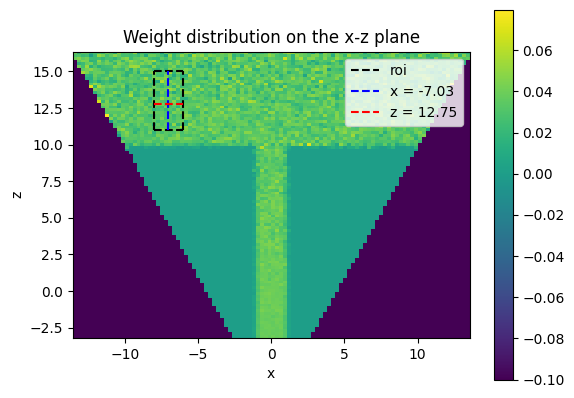

In [9]:
# One cell that takes an ROI and shows the optimal split
rois = [
    [-10, 10, -2.5, 15.0],
    [-6, 0, 5, 7.5],
    [-2, 5, 0, 2.5],
    [-7, 3, 0, 12.5],
    [0, 5, 5, 15],
    [2, 3, 0, 5],
    [-8, -6, 11, 15.0],
]

for roi in rois:
    plot_weight_image(position[:, 0], position[:, 2], weight, bins=100)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("z")
    plt.title("Weight distribution on the x-z plane")

    # Plot the region of interest
    plt.plot([roi[0], roi[0]], [roi[2], roi[3]], 'k--', label='roi')
    plt.plot([roi[1], roi[1]], [roi[2], roi[3]], 'k--')
    plt.plot([roi[0], roi[1]], [roi[2], roi[2]], 'k--')
    plt.plot([roi[0], roi[1]], [roi[3], roi[3]], 'k--')

    # Select samples in the region of interest
    x, z = position[:, 0], position[:, 2]
    mask = (x >= roi[0]) & (x <= roi[1]) & (z >= roi[2]) & (z <= roi[3])
    x, z, w = x[mask], z[mask], weight[mask]

    # Randomly select N samples
    N = min(len(x), 2000)
    indices = np.random.choice(len(x), N, replace=False)
    x, z, w = x[indices], z[indices], w[indices]

    x_split, cost_x = find_split(x, w, 'x')
    z_split, cost_z = find_split(z, w, 'z')
    gamma = 0.3
    cost_x *= (roi[3] - roi[2])**gamma  # penalize the anisotropy
    cost_z *= (roi[1] - roi[0])**gamma
    print(f"Cost_x after penalization: {cost_x}")
    print(f"Cost_z after penalization: {cost_z}")

    # Plot the optimal split
    if cost_x < cost_z:
        x_style = 'r--'
        z_style = 'b--'
    else:
        x_style = 'b--'
        z_style = 'r--'

    plt.plot([x_split, x_split], [roi[2], roi[3]], x_style, label=f'x = {x_split:.2f}')
    plt.plot([roi[0], roi[1]], [z_split, z_split], z_style, label=f'z = {z_split:.2f}')

    plt.legend()
    plt.gca().set_aspect('equal')
    plt.show()

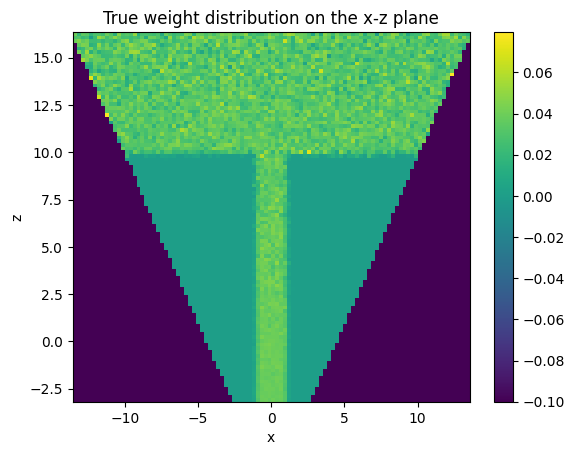

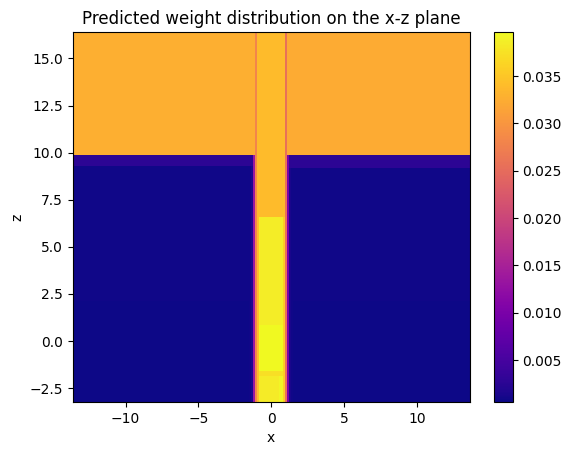

In [10]:
# Apply Decision Tree Regressor to find the optimal split recursively
x, z = position[:, 0], position[:, 2]
xz = np.stack([x, z], axis=1)
tree = DecisionTreeRegressor(criterion='squared_error', max_depth=10, min_samples_split=32000, min_samples_leaf=1000)
tree.fit(xz, weight)

def plot_tree(tree, x, z, weight):
    plot_weight_image(x, z, weight, bins=100)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("z")
    plt.title("True weight distribution on the x-z plane")
    plt.show()

    bins = 200
    xx, zz = np.meshgrid(np.linspace(np.min(x), np.max(x), bins), np.linspace(np.min(z), np.max(z), bins))
    xxz = np.stack([xx.ravel(), zz.ravel()], axis=1)
    pred = tree.predict(xxz).reshape(xx.shape)
    plt.figure()
    plt.pcolor(xx, zz, pred, cmap='plasma')
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("z")
    plt.title("Predicted weight distribution on the x-z plane")
    # plt.contour(xx, zz, pred, levels=10, colors='r')
    plt.show()

plot_tree(tree, x, z, weight)